In [15]:
import torch
import pickle 
import os
from collections import defaultdict

In [58]:
# group prediction with sequence
def reformat_pred(pred_file):
    with open(pred_file, 'rb') as f:
        pred = pickle.load(f)
    new_pred = defaultdict(dict)
    for seq_frame, v in pred.items():
        seq, frame = seq_frame.split('/')
        new_pred[seq].update({frame: v})
    with open(pred_file, "wb") as f:
        pickle.dump(new_pred, f)
    return new_pred

In [ ]:
reformat_pred('/home/andy/ipl/CenterPoint/work_dirs/ResUnet3D_test_testset/prediction.pkl')

In [60]:
with open('/home/andy/ipl/CenterPoint/work_dirs/ResUnet3D_test_testset/prediction.pkl', 'rb') as f:
    pred = pickle.load(f)

In [61]:
pred_frame = pred['1']
print(pred_frame)

{'00612_00580': {'box3d': array([[ 1.9736326e+01, -2.2388167e+00,  7.1825659e-01,  4.8419781e+00,
         2.4260035e+00,  2.1407430e+00,  2.2766683e-02],
       [ 3.5795872e+01,  5.4088879e-01,  8.8349348e-01,  4.6508536e+00,
         2.3174417e+00,  2.1926744e+00, -1.6909907e-02],
       [ 3.9123768e+01, -3.4862294e+00,  1.2647657e+00,  6.6824746e+00,
         2.8501325e+00,  2.5596371e+00,  1.4463340e-02]], dtype=float32), 'scores': array([0.73696065, 0.35886964, 0.1521025 ], dtype=float32), 'label_preds': array([0, 0, 0]), 'metadata': {'path': {'rdr_sparse_cube': None, 'rdr_tesseract': '/mnt/nas_kradar/kradar_dataset/dir_1to20/1/radar_tesseract/tesseract_00612.mat', 'rdr_cube': '/mnt/nas_kradar/kradar_dataset/dir_1to20/1/radar_zyx_cube/cube_00612.mat', 'rdr_cube_doppler': None, 'ldr_pc_64': '/mnt/nas_kradar/kradar_dataset/dir_1to20/1/os2-64/os2-64_00580.pcd', 'cam_front_img': '/mnt/nas_kradar/kradar_dataset/dir_1to20/1/cam-front/cam-front_01739.png', 'path_calib': '/mnt/nas_kradar/

In [35]:
pred_frame['box3d']

tensor([], size=(0, 7))

In [36]:
for seq, bbox in enumerate(pred_frame['box3d']):
    print(bbox)

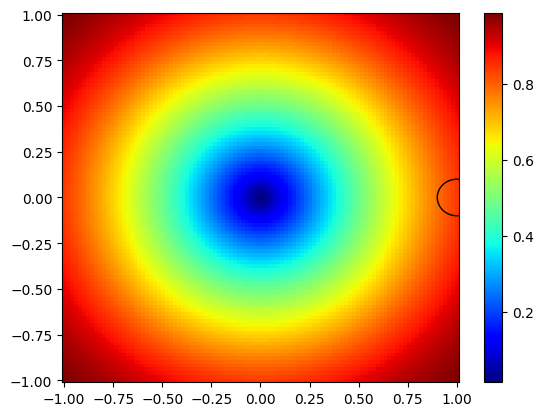

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Create a plot with pcolormesh
fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, Z, cmap='jet')

# Add a circle to the plot
circle = plt.Circle((1, 0), 0.1, color='k', fill=False)
ax.add_artist(circle)

# Add a color bar
cbar = fig.colorbar(im, ax=ax)

# Show the plot
plt.show()

In [48]:
(X[0], Y[0])

(array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
        -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
        -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
        -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
        -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
        -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
        -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
        -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
        -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
        -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
         0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
         0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
         0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
         0.31313131,  0.33333333,  0.35353535,  0.3

In [62]:
import torch.nn as nn

In [93]:

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        
        self.q_weights = [nn.Linear(hidden_dim, hidden_dim) for _ in range(self.num_heads)]
        self.k_weights = [nn.Linear(hidden_dim, hidden_dim) for _ in range(self.num_heads)]
        self.v_weights = [nn.Linear(hidden_dim, hidden_dim) for _ in range(self.num_heads)]
        self.softmax = nn.Softmax(dim=-1)
        self.linear = nn.Linear(num_heads*hidden_dim, hidden_dim)
        
    def forward(self, X):
        #B, N, D = X.shape 
        result = []
        for x in X:
            x_result = [] # H, N, D
            for head in range(self.num_heads):
                q = self.q_weights[head](x)
                k = self.k_weights[head](x)
                v = self.v_weights[head](x)
                h = self.softmax(q @ k.T / self.hidden_dim**1/2) @ v # N, D
                x_result.append(h)
            print(h.shape)
            result.append(torch.hstack(x_result)) # B, N, H*D
        print(result[0].shape)
        print(result[0].unsqueeze(dim=0).shape)
        H = torch.cat([torch.unsqueeze(r, dim=0) for r in result]) 
        print(H.shape)
        out = self.linear(H)
        return out # N, D

In [94]:
H, N, D = 3, 10, 5

selfatten_block = MultiHeadSelfAttention(D, H)


In [95]:

dummy_input = torch.rand(2, N, D)

In [102]:
selfatten_block.v_weights[0]

Linear(in_features=5, out_features=5, bias=True)

In [96]:
print(selfatten_block(dummy_input).shape)

torch.Size([10, 5])
torch.Size([10, 5])
torch.Size([10, 15])
torch.Size([1, 10, 15])
torch.Size([2, 10, 15])
torch.Size([2, 10, 5])


In [101]:
t1 = torch.rand(N, D)
t2 = torch.rand(N, D)
t3 = torch.rand(N, D)

print(torch.hstack((t1, t2, t3)).shape)


torch.Size([10, 15])
